# 分析の方針
データ分析を行う上で、必ずデータを分析する目的を考慮した上で因果関係を考察する必要がある。そこで、因果関係は疫学でも触れられているが、統計学では原因系変数の種類と結果系変数の種類によって分析手法が異なるため、ここではデータの形状別の分析指針の一例を示す。

また、エビデンスレベルが変わってしまうが、原因系変数と結果系変数を逆にすることでより因果関係を考察する材料ができる。

## ライブラリのインポート

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz as EG
from pydotplus import graph_from_dot_data as GFDD
from PIL import Image
from lifelines import CoxPHFitter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

## データの読み込み

In [2]:
df = pd.read_csv("leukemia.csv")
df.head()

,t,status,sex,logWBC,Rx
0,35,0,1,1.45,0
1,34,0,1,1.47,0
2,32,0,1,2.20,0
3,32,0,1,2.53,0
4,25,0,1,1.78,0


## 原因が質的変数で結果が質的変数
因果関係の推論としてはリスク比やオッズ比を使用し、理論値と実測値との独立性を検証するにはカイ二乗検定を使用する。ここで、リスク比は疫学的因果関係における強固性を表せる。

また、疫学的因果関係における時間的関係はRx(投与)→logWBC(白血球数)→status(効果)となり、tは時間を示す。

ここでは投与群とプラセボ群で効果に影響があるか考察する。
### 前向き研究(コホート研究)
前向き研究では原因(曝露)から結果(症例)に向けてデータを集計する観察研究の手法。エビデンスレベルとしてRCTの次に高い。

In [3]:
cross1 = pd.crosstab(df["Rx"], df["status"])
cross1

status,0,1
Rx,,
0,12,9
1,0,21


In [4]:
cross = cross1.values
risk1 = cross[0][1]/(sum(cross[0]))
risk2 = cross[1][1]/(sum(cross[1]))
print("risk rate = %.2f"%(risk2/risk1))
odds1 = (cross1[0][1] / sum(cross1[0]) / cross1[0][0] / sum(cross1[0]))
odds2 = (cross1[1][1] / sum(cross1[1]) / cross1[1][0] / sum(cross1[1]))
print("odds rate = %.2f"%(odds2/odds1))

risk rate = 2.33
odds rate = inf


C:\Users\decar\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


この場合オッズ比は反応の割合を非反応の割合で割っているためクロス集計表に0があると計算できない

status(効果)についてRx(投与群とプラセボ群)で違いが現れていることが分かる。

In [5]:
cross2 = pd.crosstab(df["sex"], df["status"])
cross2

status,0,1
sex,,
0,6,16
1,6,14


#### クロス集計表に性別の要素を加える
第三の変数を使用して結果に寄与する第三の要因を探す

In [6]:
cross3 = pd.crosstab([df["Rx"], df["sex"]], df["status"])
cross3

status  0   1
Rx sex       
0  0    6   5
   1    6   4
1  0    0  11
   1    0  10

In [7]:
cross = cross3.values
risk1 = cross[0][1]/(sum(cross[0]))
risk2 = cross[1][1]/(sum(cross[1]))
risk3 = cross[2][1]/(sum(cross[2]))
risk4 = cross[3][1]/(sum(cross[3]))
print("risk rate(Rx=0) = %.2f"%(risk2/risk1))
print("risk rate(Rx=1) = %.2f"%(risk4/risk3))

risk rate(Rx=0) = 0.88
risk rate(Rx=1) = 1.00


In [8]:
print("risk rate = %.2f"%((risk4/risk2)/(risk3/risk1)))

risk rate = 1.14


この結果から性別による差は小さいことが分かる。

### 後ろ向き研究(症例対象研究)
報告された症例からデータを集計するため時間およびコストが前向き研究と比べてかからない代わりにエビデンスレベルは前向き研究より低い。

In [9]:
cross4 = pd.crosstab(df["status"], df["Rx"])
cross4

Rx,0,1
status,,
0,12,0
1,9,21


In [10]:
cross5 = pd.crosstab([df["status"], df["sex"]], df["Rx"])
cross5

Rx          0   1
status sex       
0      0    6   0
       1    6   0
1      0    5  11
       1    4  10

In [11]:
cross6 = pd.crosstab(df["status"], [df["Rx"], df["sex"]])
cross6

Rx      0      1    
sex     0  1   0   1
status              
0       6  6   0   0
1       5  4  11  10

### 数量化理論Ⅱ類
原因系変数と結果系変数全てがこの場合ダミー変数になっているためロジスティック回帰を使用することができる。

In [12]:
df_01 = df.drop(["t", "logWBC"], axis=1)
df_01.head()

,status,sex,Rx
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [13]:
X = sm.add_constant(df_01.drop(["status"], axis=1))
model = sm.Logit(df_01["status"], X).fit_regularized()
model.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3406956737869411
            Iterations: 42
            Function evaluations: 42
            Gradient evaluations: 42


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 status   No. Observations:                   42
Model:                          Logit   Df Residuals:                       39
Method:                           MLE   Df Model:                            2
Date:                Sun, 19 Mar 2023   Pseudo R-squ.:                  0.4305
Time:                        17:53:48   Log-Likelihood:                -14.309
converged:                       True   LL-Null:                       -25.127
Covariance Type:            nonrobust   LLR p-value:                 2.003e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1823      0.606     -0.301      0.763      -1.369       1.004
sex           -0.2231      0.885     -0.252      0.801      -1.958       1.512
Rx            22.3269   1.33e+04      0.002      0.999    -2.6e+04     2.6e+04
==============================================================================

Possibly complete quasi-separation: A fraction 0.50 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

## 原因が質的変数と結果が量的変数
ここでは質的変数のラベル別で各因子について分布を確認する。

### 基礎統計量
数値として厳密に分布を知るために平均値・最大値・四分位(中央値含む)・最小値・サンプル数を表示する。ここで現れたデータを基に因果関係を考察する。

In [14]:
df.describe()

,t,status,sex,logWBC,Rx
count,42.000000,42.000000,42.000000,42.000000,42.000000
mean,12.880952,0.714286,0.476190,2.930238,0.500000
std,9.347498,0.457230,0.505487,0.917522,0.506061
min,1.000000,0.000000,0.000000,1.450000,0.000000
25%,6.000000,0.000000,0.000000,2.302500,0.000000
50%,10.500000,1.000000,0.000000,2.800000,0.500000
75%,18.500000,1.000000,1.000000,3.490000,1.000000
max,35.000000,1.000000,1.000000,5.000000,1.000000


#### 質的変数によって場合分けをする

In [15]:
df_sex0 = df.query("sex==0")
df_sex1 = df.query("sex==1")
df_sex0.describe()

,t,status,sex,logWBC,Rx
count,22.000000,22.000000,22.0,22.000000,22.000000
mean,11.045455,0.727273,0.0,2.835455,0.500000
std,4.571936,0.455842,0.0,0.671443,0.511766
min,5.000000,0.000000,0.0,1.500000,0.000000
25%,8.000000,0.250000,0.0,2.312500,0.000000
50%,10.500000,1.000000,0.0,2.840000,0.500000
75%,12.750000,1.000000,0.0,3.165000,1.000000
max,22.000000,1.000000,0.0,4.430000,1.000000


In [16]:
df_sex1.describe()

,t,status,sex,logWBC,Rx
count,20.000000,20.000000,20.0,20.00000,20.000000
mean,14.900000,0.700000,1.0,3.03450,0.500000
std,12.540041,0.470162,0.0,1.13863,0.512989
min,1.000000,0.000000,1.0,1.45000,0.000000
25%,3.750000,0.000000,1.0,2.15250,0.000000
50%,12.000000,1.000000,1.0,2.68500,0.500000
75%,23.500000,1.000000,1.0,4.02250,1.000000
max,35.000000,1.000000,1.0,5.00000,1.000000


In [17]:
df_Rx0 = df.query("Rx==0")
df_Rx1 = df.query("Rx==1")
df_Rx0.describe()

,t,status,sex,logWBC,Rx
count,21.000000,21.000000,21.000000,21.000000,21.0
mean,17.095238,0.428571,0.476190,2.636190,0.0
std,9.999524,0.507093,0.511766,0.773876,0.0
min,6.000000,0.000000,0.000000,1.450000,0.0
25%,9.000000,0.000000,0.000000,2.160000,0.0
50%,16.000000,0.000000,0.000000,2.570000,0.0
75%,23.000000,1.000000,1.000000,2.960000,0.0
max,35.000000,1.000000,1.000000,4.430000,0.0


In [18]:
df_Rx1.describe()

,t,status,sex,logWBC,Rx
count,21.000000,21.0,21.000000,21.000000,21.0
mean,8.666667,1.0,0.476190,3.224286,1.0
std,6.467869,0.0,0.511766,0.972279,0.0
min,1.000000,1.0,0.000000,1.500000,1.0
25%,4.000000,1.0,0.000000,2.420000,1.0
50%,8.000000,1.0,0.000000,3.060000,1.0
75%,12.000000,1.0,1.000000,3.970000,1.0
max,23.000000,1.0,1.000000,5.000000,1.0


In [19]:
df_status0 = df.query("status==0")
df_status1 = df.query("status==1")
df_status0.describe()

,t,status,sex,logWBC,Rx
count,12.000000,12.0,12.000000,12.000000,12.0
mean,20.833333,0.0,0.500000,2.245833,0.0
std,10.590161,0.0,0.522233,0.538153,0.0
min,6.000000,0.0,0.000000,1.450000,0.0
25%,10.750000,0.0,0.000000,1.952500,0.0
50%,19.500000,0.0,0.500000,2.180000,0.0
75%,32.000000,0.0,1.000000,2.625000,0.0
max,35.000000,0.0,1.000000,3.200000,0.0


In [20]:
df_status1.describe()

,t,status,sex,logWBC,Rx
count,30.000000,30.0,30.000000,30.000000,30.000000
mean,9.700000,1.0,0.466667,3.204000,0.700000
std,6.659968,0.0,0.507416,0.899439,0.466092
min,1.000000,1.0,0.000000,1.500000,0.000000
25%,5.000000,1.0,0.000000,2.457500,0.000000
50%,8.000000,1.0,0.000000,3.055000,1.000000
75%,12.750000,1.0,1.000000,3.877500,1.000000
max,23.000000,1.0,1.000000,5.000000,1.000000


### 分布を箱ひげ図で確認
箱ひげ図を使用することで値の集中が確認できる。

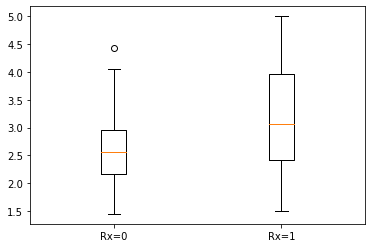

In [21]:
plt.boxplot([df_Rx0["logWBC"], df_Rx1["logWBC"]], labels=["Rx=0", "Rx=1"])
plt.show()

C:\Users\decar\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


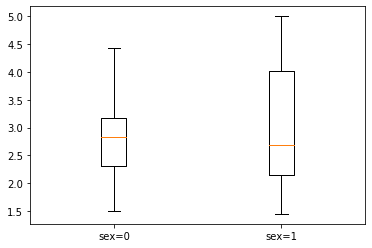

In [22]:
plt.boxplot([df_sex0["logWBC"], df_sex1["logWBC"]], labels=["sex=0", "sex=1"])
plt.show()

C:\Users\decar\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


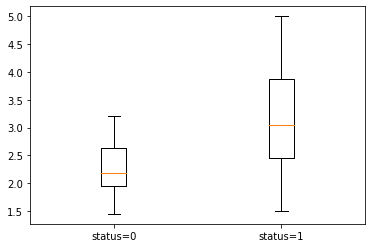

In [23]:
plt.boxplot([df_status0["logWBC"], df_status1["logWBC"]], labels=["status=0", "status=1"])
plt.show()

その他にもヒストグラムを使用してデータの詳細な分布を見ることもできるが、分割する数に注意が必要。
### T検定
また、2変数間で平均値に差があるかを検証する時は対応のないT検定を使用する。

In [24]:
columns = ["Rx", "status", "sex"]
for col in columns:
    print("p-value col is %s, values is logWBC"%(col))
    xa = df.query("%s==0"%(col))["logWBC"]
    xb = df.query("%s==1"%(col))["logWBC"]
    f, p = stats.bartlett(xa, xb)
    if (2 * p) <= 0.05:
        t, p = stats.ttest_ind(xa, xb, equal_var=False)
    else:
        t, p = stats.ttest_ind(xa, xb, equal_var=True)
    print("%.2f"%(p))

p-value col is Rx, values is logWBC
0.04
p-value col is status, values is logWBC
0.00
p-value col is sex, values is logWBC
0.50


statusとRxについて値が異なることでそれぞれlogWBCについて有意差が現れていることが分かる。また、性別はlogWBCに対して有意差があるとは言えないことが分かる。

※ただしstatusは最終的な「結果」であるため因果関係としてはlogWBC→statusとなる

### 数量化理論Ⅰ類
logWBCを量的な結果系変数として他を質的な結果系変数とすることで重回帰分析で数量化理論Ⅰ類が使える。

In [25]:
df_09 = df.drop(["t"], axis=1)
df_09.head()

,status,sex,logWBC,Rx
0,0,1,1.45,0
1,0,1,1.47,0
2,0,1,2.20,0
3,0,1,2.53,0
4,0,1,1.78,0


In [26]:
X = sm.add_constant(df_09.drop("logWBC", axis=1))
model = sm.OLS(df_09["logWBC"], X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logWBC   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     4.090
Date:                Sun, 19 Mar 2023   Prob (F-statistic):             0.0131
Time:                        17:53:49   Log-Likelihood:                -49.598
No. Observations:                  42   AIC:                             107.2
Df Residuals:                      38   BIC:                             114.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1337      0.271      7.863      0.000       1.584       2.683
status         0.9233      0.366      2.525      0.016       0.183       1.664
sex            0.2242      0.256      0.875      0.387      -0.294       0.743
Rx             0.0605      0.330      0.183      0.856      -0.608       0.729
==============================================================================
Omnibus:                        0.885   Durbin-Watson:                   1.453
Prob(Omnibus):                  0.643   Jarque-Bera (JB):                0.889
Skew:                           0.178   Prob(JB):                        0.641
Kurtosis:                       2.383   Cond. No.                         5.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 直行表の分析
logWBCを評価値として考えることでDoEの直行表のように分析でき、評価値と分析対象の変数と質的な値に対して交絡する因子を考慮したデータの分布と平均値が得られる。

In [27]:
columns = ["Rx", "sex", "status"]
vals = []
name1 = []
cnt = []
count = 0
for col in columns:
    tmp = []
    name = []
    tmpc = []
    value = list(set(df[col].values))
    for val in value:
        df_q = df_09.query("%s==%d"%(col, val))
        tmp.append(df_q["logWBC"].values.tolist())
        name.append(col+"_"+str(val))
        tmpc.append(count)
        count = count + 1
    vals.append(tmp)
    name1.append(name)
    cnt.append(tmpc)

C:\Users\decar\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
C:\Users\decar\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


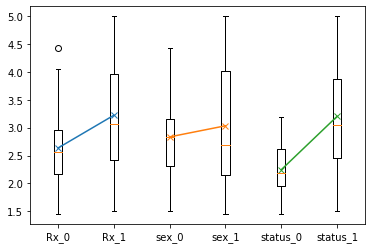

Rx_1 - Rx_0 = 0.59
sex_1 - sex_0 = 0.20
status_1 - status_0 = 0.96


In [28]:
count = 0
for i in range(len(vals)):
    plt.boxplot(vals[i], positions=cnt[i], labels=name1[i])
    ave = []
    for j in range(len(vals[i])):
        ave.append(sum(vals[i][j])/len(vals[i][j]))
    plt.plot(cnt[i], ave, marker="x")
plt.show()
print("Rx_1 - Rx_0 = %.2f"%(df_Rx1["logWBC"].mean()-df_Rx0["logWBC"].mean()))
print("sex_1 - sex_0 = %.2f"%(df_sex1["logWBC"].mean()-df_sex0["logWBC"].mean()))
print("status_1 - status_0 = %.2f"%(df_status1["logWBC"].mean()-df_status0["logWBC"].mean()))

この結果から因果関係としてRxがlogWBCに影響を与えていることが分かる。また、sex(性別)の影響は他と比べて少ない。

※ここで、statusは結果となっているため原因と結果を間違えないように。

### 効果有りと効果無しに投与群とプラセボ群における因果推論
結果的に効果があった群と効果がなかった群でデータを分けて、それぞれで投与群とプラセボ群におけるlogWBCの平均値の差を確認する。

In [29]:
df_status1_Rx1 = df_status1.query("Rx==1")
df_status1_Rx0 = df_status1.query("Rx==0")
df_status0_Rx1 = df_status0.query("Rx==1")
df_status0_Rx0 = df_status0.query("Rx==0")

In [30]:
print("効果があった群で投与群とプラセボ群の効果の差\n%.2f"%(df_status1_Rx1["logWBC"].mean()-df_status1_Rx0["logWBC"].mean()))

効果があった群で投与群とプラセボ群の効果の差
0.07


In [31]:
print("効果が無かった群で投与群とプラセボ群の効果の差\n%.2f"%(df_status0_Rx1["logWBC"].mean()-df_status0_Rx0["logWBC"].mean()))

効果が無かった群で投与群とプラセボ群の効果の差
nan


In [32]:
df_Rx1_status1 = df_Rx1.query("status==1")
df_Rx1_status0 = df_Rx1.query("status==0")
df_Rx0_status1 = df_Rx0.query("status==1")
df_Rx0_status0 = df_Rx0.query("status==0")

In [33]:
print("投与群で効果別の差\n%.2f"%(df_Rx1_status1["logWBC"].mean()-df_Rx1_status0["logWBC"].mean()))

投与群で効果別の差
nan


In [34]:
print("プラセボ群で効果別の差\n%.2f"%(df_Rx0_status1["logWBC"].mean()-df_Rx0_status0["logWBC"].mean()))

プラセボ群で効果別の差
0.91


効果については無かった群だと片方のデータのレコードが無いため計算ができなかったが、効果があった群では投与群とプラセボ群で平均的に0.91の差がある事が分かった。

また、投与群では片方のデータのレコードが無いため計算ができなかったが、プラセボ群では効果別にlogWBCに対して0.91の差がある事が分かった。

ここで、Rxとstatusのクロス集計表からデータが無いものはstatusが1でRxが0のデータフレームであることがわかる。そのため、単体で効果を確認すると20.83となっている。

## 原因が量的変数で結果が量的変数の場合
原因系変数も結果系変数も共に量的変数である場合は回帰係数などを使用して因果関係を明らかにする。ただし、係数がどの程度適合しているかを検証するために決定係数と自由度調整済み決定係数も見る。

ここではlogWBCについて影響する項目について考察する。

### 原因系変数が1つの場合

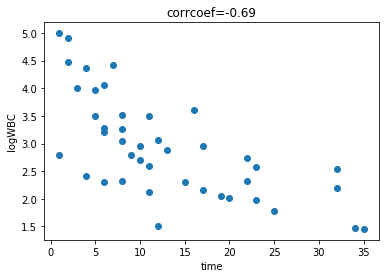

In [35]:
plt.scatter(df["t"], df["logWBC"])
plt.ylabel("logWBC")
plt.xlabel("time")
plt.title("corrcoef=%.2f"%(np.corrcoef(df["t"].values, df["logWBC"].values)[0][1]))
plt.show()

In [36]:
model1 = LinearRegression()
model1.fit(df["t"].values.reshape(-1, 1), df["logWBC"])
y_pred1 = model1.predict(df["t"].values.reshape(-1, 1))
a = model1.coef_[0]
b = model1.intercept_
R2 = r2_score(df["logWBC"], y_pred1)

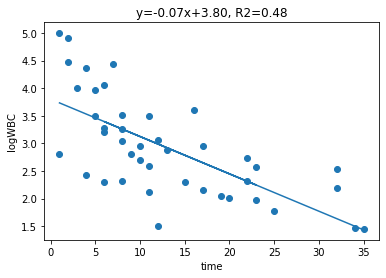

In [37]:
plt.scatter(df["t"], df["logWBC"])
plt.plot(df["t"], y_pred1)
plt.ylabel("logWBC")
plt.xlabel("time")
plt.title("y=%.2fx+%.2f, R2=%.2f"%(a, b, R2))
plt.show()

### 原因系変数が複数の場合

In [38]:
X2 = sm.add_constant(df.drop("logWBC", axis=1))
model2 = sm.OLS(df["logWBC"], X2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logWBC   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     11.65
Date:                Sun, 19 Mar 2023   Prob (F-statistic):           3.19e-06
Time:                        17:53:50   Log-Likelihood:                -38.353
No. Observations:                  42   AIC:                             86.71
Df Residuals:                      37   BIC:                             95.40
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4360      0.330     10.408      0.000       2.767       4.105
t             -0.0685      0.013     -5.119      0.000      -0.096      -0.041
status         0.3399      0.306      1.112      0.273      -0.279       0.959
sex            0.4722      0.204      2.309      0.027       0.058       0.887
Rx            -0.1832      0.260     -0.703      0.486      -0.711       0.345
==============================================================================
Omnibus:                        0.957   Durbin-Watson:                   2.241
Prob(Omnibus):                  0.620   Jarque-Bera (JB):                0.879
Skew:                          -0.332   Prob(JB):                        0.644
Kurtosis:                       2.751   Cond. No.                         66.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 多重共線性の確認
多重共線性についてp値および相関ならびに自由度調整済み決定係数から考える。ここで、変数選択をすることで擬相関を考慮した上での因果関係を考える。

In [39]:
df.corr()

,t,status,sex,logWBC,Rx
t,1.000000,-0.544584,2.084431e-01,-0.689399,-4.563114e-01
status,-0.544584,1.000000,-3.015113e-02,0.477485,6.324555e-01
sex,0.208443,-0.030151,1.000000e+00,0.109659,-7.409893e-17
logWBC,-0.689399,0.477485,1.096593e-01,1.000000,3.243650e-01
Rx,-0.456311,0.632456,-7.409893e-17,0.324365,1.000000e+00


In [40]:
X3 = X2.drop("Rx", axis=1)
model3 = sm.OLS(df["logWBC"], X3).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logWBC   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     15.58
Date:                Sun, 19 Mar 2023   Prob (F-statistic):           9.16e-07
Time:                        17:53:50   Log-Likelihood:                -38.632
No. Observations:                  42   AIC:                             85.26
Df Residuals:                      38   BIC:                             92.22
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4050      0.325     10.477      0.000       2.747       4.063
t             -0.0667      0.013     -5.110      0.000      -0.093      -0.040
status         0.2305      0.261      0.882      0.383      -0.298       0.759
sex            0.4626      0.203      2.283      0.028       0.052       0.873
==============================================================================
Omnibus:                        1.351   Durbin-Watson:                   2.256
Prob(Omnibus):                  0.509   Jarque-Bera (JB):                1.035
Skew:                          -0.382   Prob(JB):                        0.596
Kurtosis:                       2.913   Cond. No.                         64.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
X4 = X3.drop("status", axis=1)
model4 = sm.OLS(df["logWBC"], X4).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logWBC   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     23.11
Date:                Sun, 19 Mar 2023   Prob (F-statistic):           2.40e-07
Time:                        17:53:50   Log-Likelihood:                -39.058
No. Observations:                  42   AIC:                             84.12
Df Residuals:                      39   BIC:                             89.33
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6428      0.181     20.105      0.000       3.276       4.009
t             -0.0731      0.011     -6.723      0.000      -0.095      -0.051
sex            0.4808      0.201      2.391      0.022       0.074       0.887
==============================================================================
Omnibus:                        0.701   Durbin-Watson:                   2.318
Prob(Omnibus):                  0.704   Jarque-Bera (JB):                0.660
Skew:                          -0.282   Prob(JB):                        0.719
Kurtosis:                       2.759   Cond. No.                         36.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ここで、変数全てのp値が5%を下回ったため、この重回帰分析の結果を使用する。そのため本来の回帰式は

logWBC=0.48*(性別)-0.07*(時間)+3.64

となる。
### VIFを用いた多重共線性への対応
VIFを用いることで各変数の相関行列の逆行列における対角要素の中で数値の高い要素が多重共線性の要因と考えることができる。

In [42]:
corr = df.drop("logWBC", axis=1).corr()
corr_inv = np.linalg.inv(corr.values)
df_corr_inv = pd.DataFrame(corr_inv)
df_corr_inv.columns = corr.columns
df_corr_inv.index = corr.columns
vif = []
for col in corr.columns:
    vif.append([col, df_corr_inv.at[col, col]])
df_vif = pd.DataFrame(vif)
df_vif.columns = ["変数名", "VIF"]
df_vif.index = corr.columns
df_corr_inv

,t,status,sex,Rx
t,1.552180,0.646951,-0.304035,0.299110
status,0.646951,1.938846,-0.076394,-0.931023
sex,-0.304035,-0.076394,1.061071,-0.090419
Rx,0.299110,-0.931023,-0.090419,1.725318


In [43]:
df_vif.sort_values("VIF", ascending=False)

,変数名,VIF
status,status,1.938846
Rx,Rx,1.725318
t,t,1.552180
sex,sex,1.061071


ここで最も数値の大きいstatusを排除する

In [44]:
X_vif = sm.add_constant(df.drop(["logWBC", "status"], axis=1))
model_vif = sm.OLS(df["logWBC"], X_vif).fit()
model_vif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logWBC   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     15.03
Date:                Sun, 19 Mar 2023   Prob (F-statistic):           1.32e-06
Time:                        17:53:50   Log-Likelihood:                -39.044
No. Observations:                  42   AIC:                             86.09
Df Residuals:                      38   BIC:                             93.04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6708      0.255     14.414      0.000       3.155       4.186
t             -0.0740      0.012     -5.946      0.000      -0.099      -0.049
sex            0.4843      0.205      2.365      0.023       0.070       0.899
Rx            -0.0357      0.225     -0.159      0.875      -0.491       0.420
==============================================================================
Omnibus:                        0.626   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.731   Jarque-Bera (JB):                0.644
Skew:                          -0.267   Prob(JB):                        0.725
Kurtosis:                       2.710   Cond. No.                         50.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

このようにVIFの大きい値から変数を削除していく手法もある
## 原因が量的変数で結果が質的変数の場合
原因系変数が量的変数で結果系変数が質的変数の場合は分類系教師あり学習を使用する。ここで、分かりやすい因果関係を明らかにする場合はロジスティック回帰や線形SVMなどを使用して決定境界の係数を使用する。ただし、係数の影響について考慮しやすくするためScikit-LearnではなくStatsmodelsを使用する。

ここではstatus(効果)について影響する項目について考察する。

### 原因系変数が一つの場合

In [45]:
X5 = sm.add_constant(df["logWBC"])
model5 = sm.Logit(df["status"], X5).fit_regularized()
model5.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.45339720352061896
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 status   No. Observations:                   42
Model:                          Logit   Df Residuals:                       40
Method:                           MLE   Df Model:                            1
Date:                Sun, 19 Mar 2023   Pseudo R-squ.:                  0.2422
Time:                        17:53:50   Log-Likelihood:                -19.043
converged:                       True   LL-Null:                       -25.127
Covariance Type:            nonrobust   LLR p-value:                 0.0004858
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0344      1.771     -2.278      0.023      -7.505      -0.563
logWBC         1.8644      0.697      2.674      0.007       0.498       3.231
==============================================================================
"""

### 原因系変数が複数の場合

In [46]:
X6 = sm.add_constant(df.drop(["status"], axis=1))
model6 = sm.Logit(df["status"], X6).fit_regularized()
model6.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.19982503727822173
            Iterations: 40
            Function evaluations: 43
            Gradient evaluations: 40


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 status   No. Observations:                   42
Model:                          Logit   Df Residuals:                       37
Method:                           MLE   Df Model:                            4
Date:                Sun, 19 Mar 2023   Pseudo R-squ.:                  0.6660
Time:                        17:53:50   Log-Likelihood:                -8.3927
converged:                       True   LL-Null:                       -25.127
Covariance Type:            nonrobust   LLR p-value:                 9.573e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.0006      5.655     -0.884      0.377     -16.085       6.084
t             -0.2207      0.171     -1.291      0.197      -0.556       0.114
sex            4.2593      2.932      1.453      0.146      -1.486      10.005
logWBC         2.4628      1.881      1.309      0.190      -1.224       6.149
Rx            17.9450    750.688      0.024      0.981   -1453.377    1489.267
==============================================================================

Possibly complete quasi-separation: A fraction 0.50 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

目立った有意差は無いが。ここではlogWBCと性別と時間が影響していることが分かる。

他にも決定木の分類過程を可視化することで分類の順序関係を見ることでより複雑なデータの因果関係を考察することができる。

#### オッズ比
ロジスティック回帰で多変量解析を行った場合に自然対数を係数でべき乗するとオッズ比になる。ここで、この各変数のオッズ比は疫学的因果関係における量-反応関係になる。

In [47]:
coef_odds = []
for col in X6.columns:
    if col != "const":
        coef_odds.append([col, np.exp(model6.params[col]), model6.params[col]])
df_odds = pd.DataFrame(coef_odds)
df_odds.columns = ["変数名", "オッズ比", "係数"]
df_odds

,変数名,オッズ比,係数
0,t,8.019791e-01,-0.220673
1,sex,7.076322e+01,4.259339
2,logWBC,1.173754e+01,2.462793
3,Rx,6.214916e+07,17.945048


#### 分類寄与率の算出と分類過程の可視化

In [48]:
model7 = DecisionTreeClassifier()
model7.fit(df.drop("status", axis=1), df["status"])
imp = model7.feature_importances_
dfi = pd.DataFrame(imp)
dfi.index = df.drop("status", axis=1).columns
dfi.columns = ["重要度"]
dfi

,重要度
t,0.125417
sex,0.000000
logWBC,0.474583
Rx,0.400000


この結果から性別は効果に影響していないことが分かる。また、効果には投与群かプラセボ群か(Rx)とlogWBCだけで80%を超えている。

In [49]:
class_name = list(set(df["status"].values))
for i in range(len(class_name)):
    class_name[i] = str(class_name[i])
dotdata = EG(model7, filled=True, rounded=True, class_names=class_name, feature_names=df.drop("status", axis=1).columns, out_file=None)
graph = GFDD(dotdata)
graph.write_png("CART.png")

True

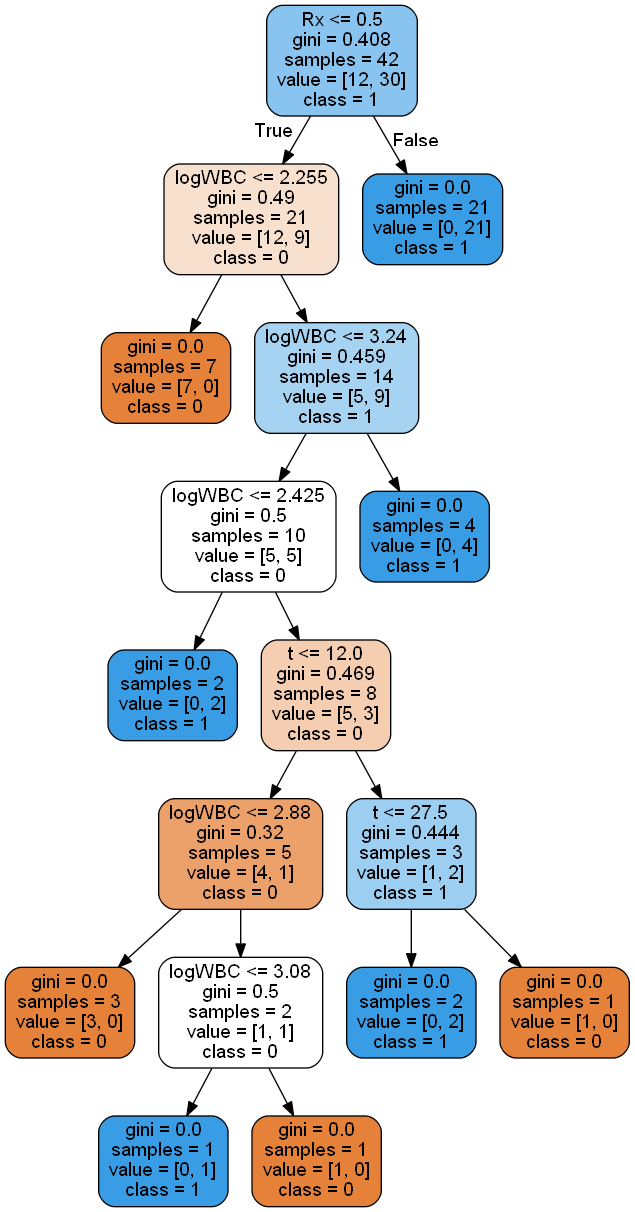

In [50]:
im = Image.open("CART.png")
im

この結果からstatus(効果)に関わる変数の順序と条件が分かる。

# 補足

## 時間とクラスを用いた効果量の測定
今回使用しているデータセットには時間の要素が入っている。そこで、Cox比例ハザードモデルを使用してハザード比を基に効果量を考察する。

In [51]:
model8 = CoxPHFitter()
model8.fit(df,duration_col="t",event_col="status")
model8.print_summary()

<lifelines.CoxPHFitter: fitted with 42 observations, 12 censored>
      duration col = 't'
         event col = 'status'
number of subjects = 42
  number of events = 30
    log-likelihood = -69.59
  time fit was run = 2023-03-19 08:53:52 UTC

---
        coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
sex     0.31      1.37      0.45 0.69   0.49      1.03       -0.58        1.21
logWBC  1.68      5.38      0.34 5.00 <0.005     20.71        1.02        2.34
Rx      1.50      4.50      0.46 3.26 <0.005      9.80        0.60        2.41
---
Concordance = 0.85
Log-likelihood ratio test = 47.19 on 3 df, -log2(p)=31.55


C:\Users\decar\Anaconda3\lib\site-packages\lifelines\utils\__init__.py:925: ConvergenceWarning: Column Rx have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['status'].astype(bool)
>>> print(df.loc[events, 'Rx'].var())
>>> print(df.loc[~events, 'Rx'].var())

A very low variance means that the column Rx completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression 
  warnings.warn(warning_text, ConvergenceWarning)


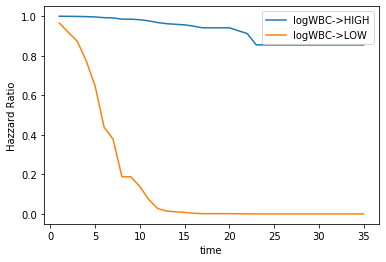

In [52]:
pred = model8.predict_survival_function(df)
plt.plot(pred.index, pred[0].values, label="logWBC->HIGH")
plt.plot(pred.index, pred[16].values, label="logWBC->LOW")
plt.legend()
plt.ylabel("Hazzard Ratio")
plt.xlabel("time")
plt.show()

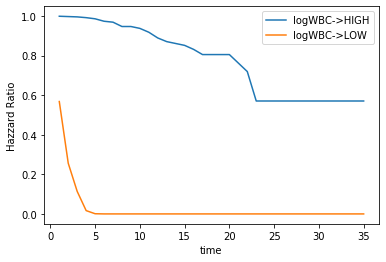

In [53]:
plt.plot(pred.index, pred[25].values, label="logWBC->HIGH")
plt.plot(pred.index, pred[41].values, label="logWBC->LOW")
plt.legend()
plt.ylabel("Hazzard Ratio")
plt.xlabel("time")
plt.show()

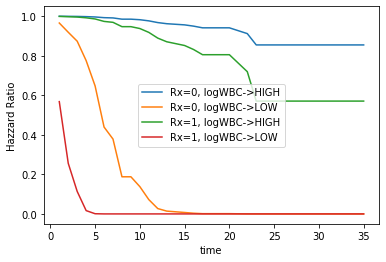

In [54]:
plt.plot(pred.index, pred[0].values, label="Rx=0, logWBC->HIGH")
plt.plot(pred.index, pred[16].values, label="Rx=0, logWBC->LOW")
plt.plot(pred.index, pred[25].values, label="Rx=1, logWBC->HIGH")
plt.plot(pred.index, pred[41].values, label="Rx=1, logWBC->LOW")
plt.legend()
plt.ylabel("Hazzard Ratio")
plt.xlabel("time")
plt.show()

この結果から時間という要素で考えると投与群とプラセボ群よりlogWBCがハザード比に影響していることが分かる。

また、確実に投与群はプラセボ群により値が低くなっていることが分かる。